In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from pathlib import Path

In [2]:
# configure df options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

pd.options.display.float_format = '{:,.5f}'.format

%matplotlib inline

### Read in top 5 stations

In [3]:
station_count = 5

In [4]:
df = pd.read_csv('../../data/station/stations.csv')

In [5]:
station_codes = df.iloc[:station_count]['code'].to_numpy()

In [6]:
station_codes

array(['SONDOC', 'LOCTHUAN', 'BENTRAI', 'BINHDAI', 'ANTHUAN'],
      dtype=object)

### Read in top 5 station train/test dataset

In [7]:
train_start_year = 2002
train_end_year = 2010

test_year = 2011

value_field = 'max'
season_length = 365

train_station_data = {}  # dictionary by station code
test_station_data = {} # dictionary by station code

In [8]:
for code in station_codes:
    # train
    df = pd.read_csv(f'../../data/train/{code}.csv', parse_dates=['date'])
    
    df.set_index('date', inplace=True)
    df.index.freq = 'D'
    
    train_station_data[code] = df
    
    # test
    df = pd.read_csv(f'../../data/test/{code}-{test_year}.csv', parse_dates=['date'])
    
    df.set_index('date', inplace=True)
    df.index.freq = 'D'
    
    test_station_data[code] = df

### Augmented Dickey-Fuller Test

In [9]:
from statsmodels.tsa.stattools import adfuller

In [10]:
def adf_check(df, code, field):
    result = adfuller(df[field], autolag='AIC')

    print(f'Augmented Dickey-Fuller Test of Station {code} on field {field}:')
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']

    for value, label in zip(result, labels):
        print(f'{label}: {value}')
    
    if result[1] <= 0.05:
        print(f'{field} of station {code} is stationary!!!')
    else:
        print(f'{field} of station {code} is NON-STATIONARY :(')

In [11]:
for code, df in train_station_data.items():
    adf_check(df, code, value_field)
    print(80 * '-')

Augmented Dickey-Fuller Test of Station SONDOC on field max:
ADF Test Statistic: -4.048357143422186
p-value: 0.001177426575819273
#Lags Used: 27
Number of Observations Used: 3259
max of station SONDOC is stationary!!!
--------------------------------------------------------------------------------
Augmented Dickey-Fuller Test of Station LOCTHUAN on field max:
ADF Test Statistic: -4.90115663359483
p-value: 3.469402178091689e-05
#Lags Used: 28
Number of Observations Used: 3258
max of station LOCTHUAN is stationary!!!
--------------------------------------------------------------------------------
Augmented Dickey-Fuller Test of Station BENTRAI on field max:
ADF Test Statistic: -4.7635117482967155
p-value: 6.383521453463726e-05
#Lags Used: 29
Number of Observations Used: 3257
max of station BENTRAI is stationary!!!
--------------------------------------------------------------------------------
Augmented Dickey-Fuller Test of Station BINHDAI on field max:
ADF Test Statistic: -5.4887111582

### Verify ARIMA requirements

In [12]:
import random

#### Pick a random station as an example

In [13]:
station_code = [*train_station_data.keys()][random.randint(0, station_count - 1)]

station_code

'BINHDAI'

In [14]:
train_data = train_station_data[station_code][value_field]

#### Seasonal Decomporision

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [16]:
plt.rcParams['figure.figsize'] = (20, 10)

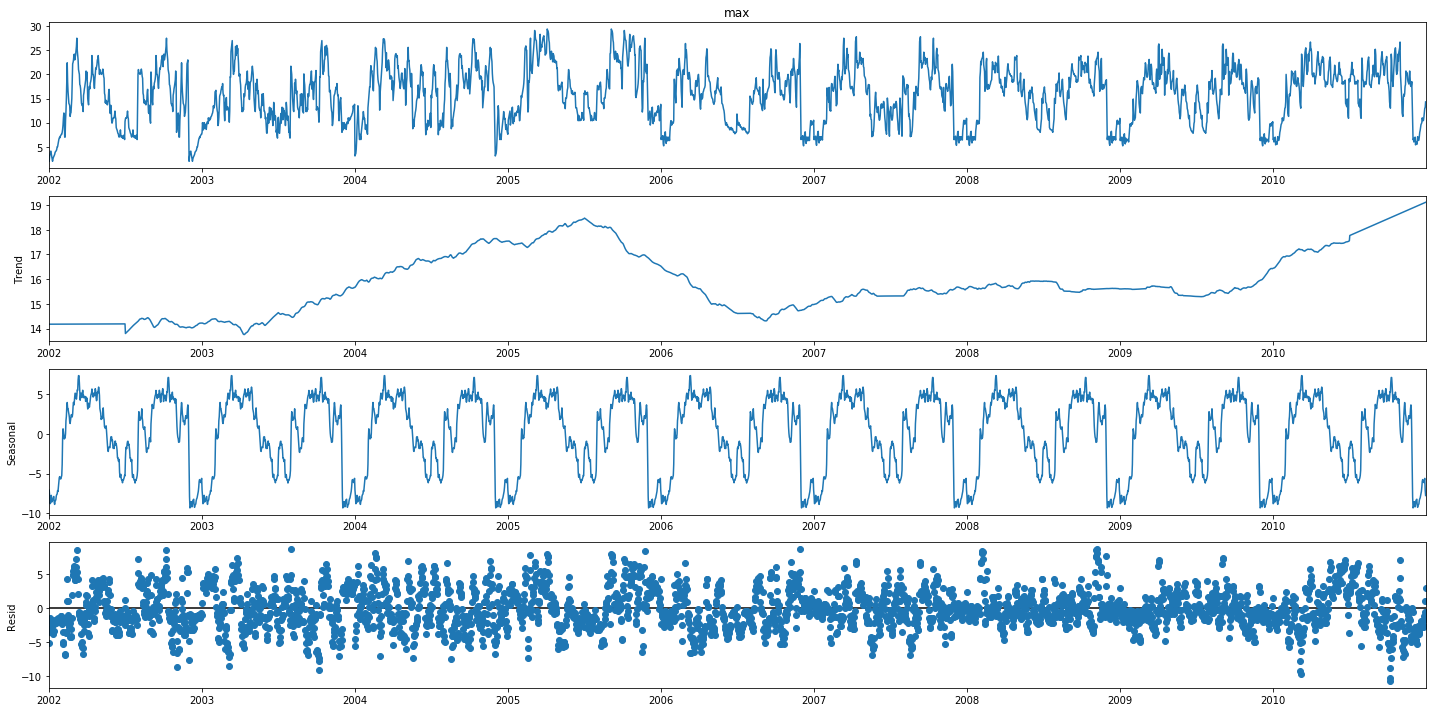

In [17]:
p = seasonal_decompose(train_data, model='additive', period=season_length, extrapolate_trend=season_length).plot();

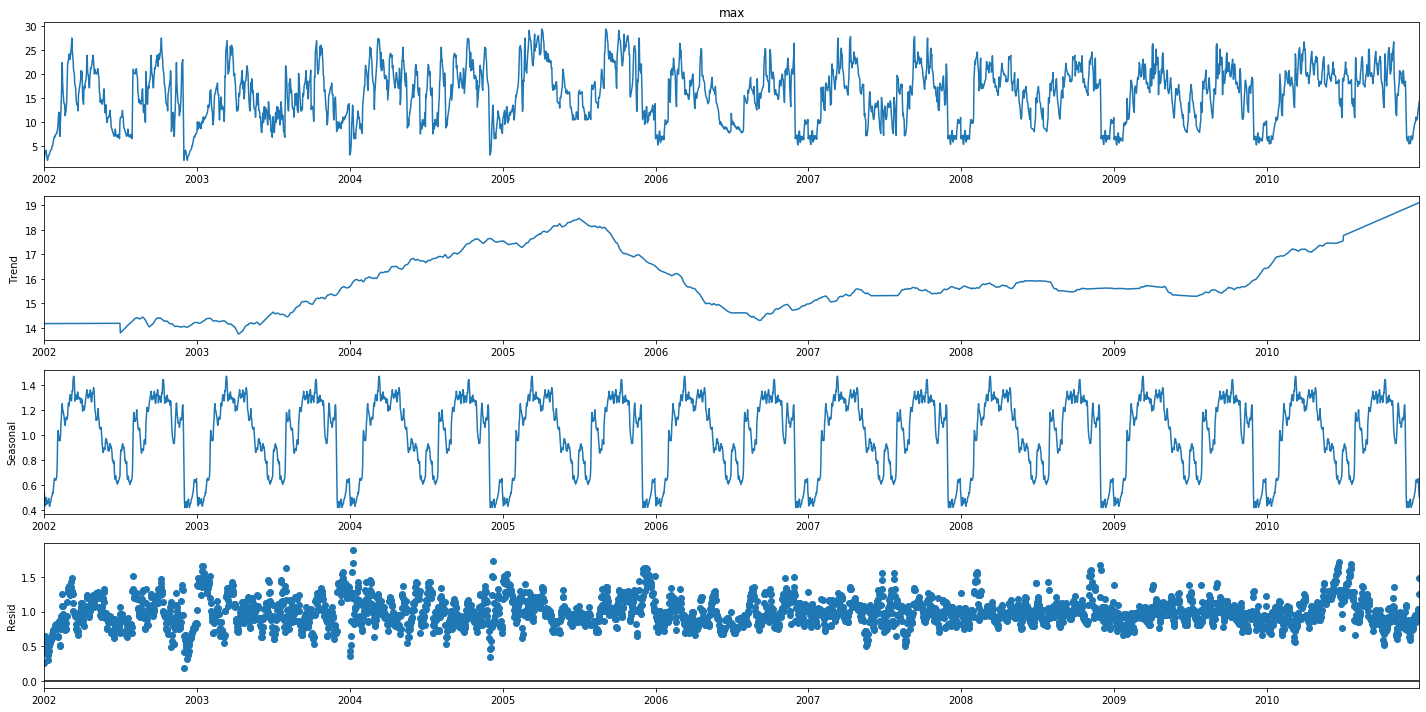

In [18]:
p = seasonal_decompose(train_data, model='multiplicative', period=season_length, extrapolate_trend=season_length).plot()

#### Visualize value changes (percentage)

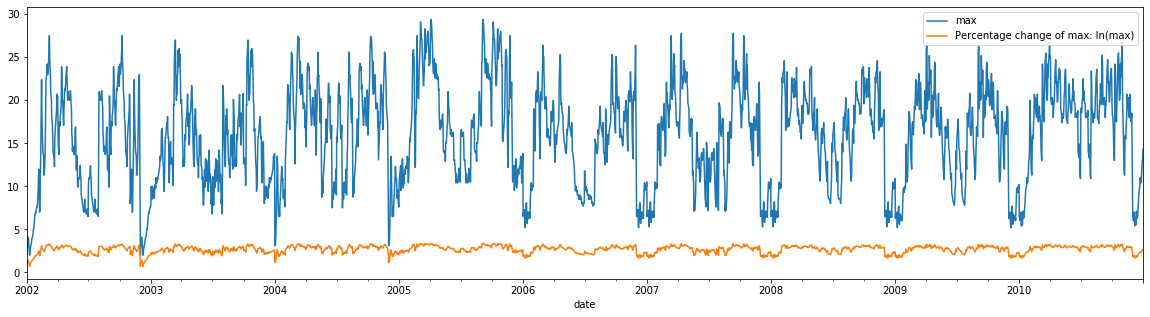

In [19]:
df = pd.DataFrame()
df[value_field] = train_data

col = f'Percentage change of {value_field}: ln({value_field})'
df[col] = np.log(train_data)

df.plot(figsize=(20, 5));

#### SMA - Simple Moving Average

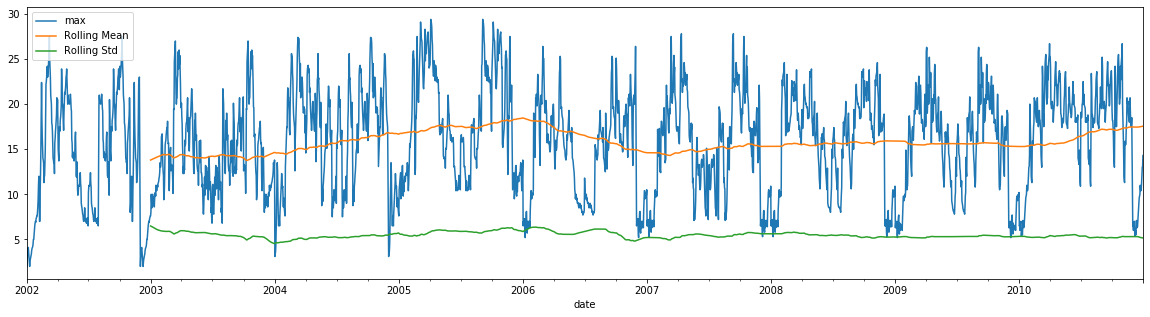

In [20]:
train_data.plot(figsize=(20, 5))
df[value_field].rolling(window=season_length).mean().plot(label='Rolling Mean')
df[value_field].rolling(window=season_length).std().plot(label='Rolling Std')
plt.legend(loc='upper left');

There is another trend on of 4 years (2005, 2006)

#### EWMA - Exponentially-weighted moving average

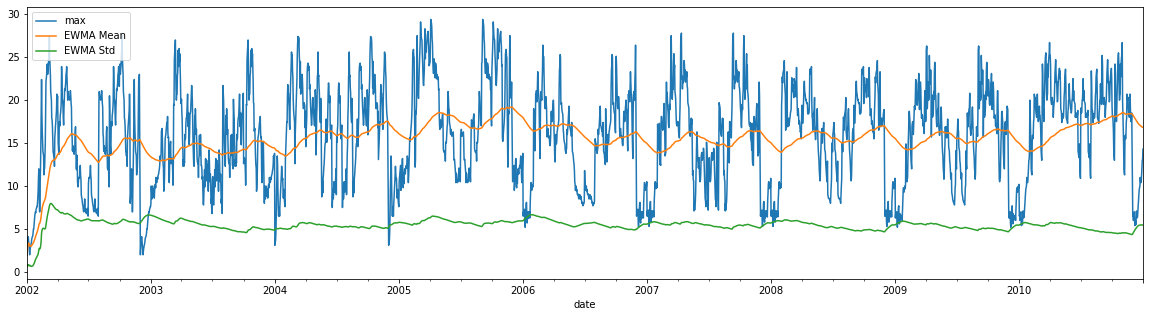

In [21]:
train_data.plot(figsize=(20, 5))
df[value_field].ewm(span=season_length).mean().plot(label='EWMA Mean')
df[value_field].ewm(span=season_length).std().plot(label='EWMA Std')
plt.legend(loc='upper left');

#### Autocovariance, Autocorrelation, and Partial Autocorrelation

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw, pacf_ols

In [23]:
plt.rcParams['figure.figsize'] = (20, 5)

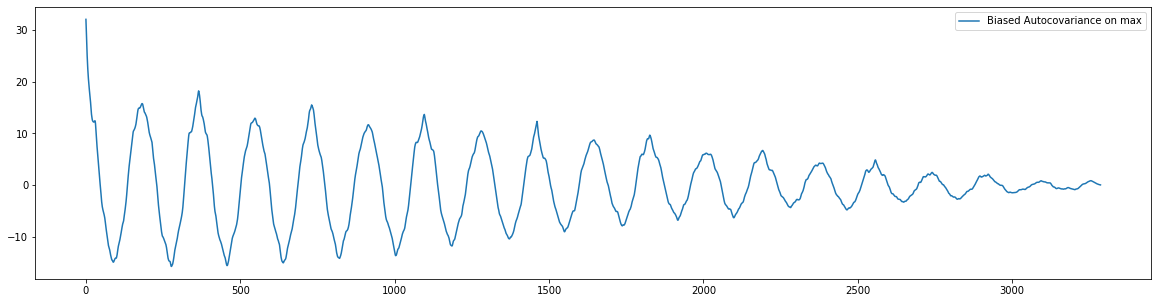

In [24]:
# Biased Autocovariance
plt.plot(acovf(train_data, fft=True), label='Biased Autocovariance on max')
plt.legend();

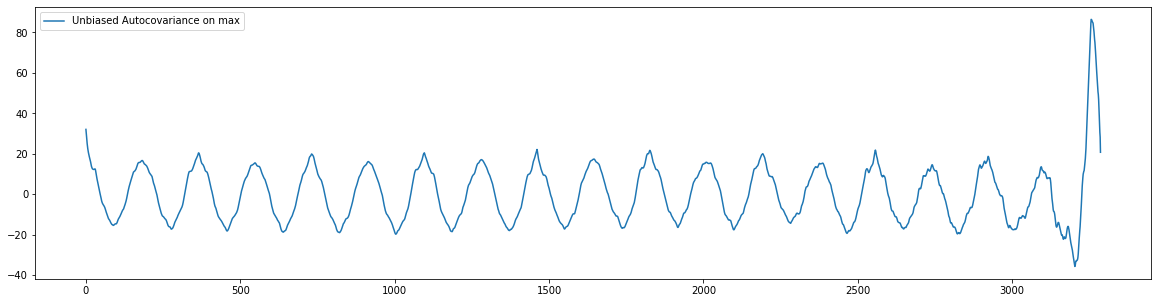

In [25]:
# Unbiased Autocovariance
plt.plot(acovf(train_data, fft=True, unbiased=True), label='Unbiased Autocovariance on max')
plt.legend();

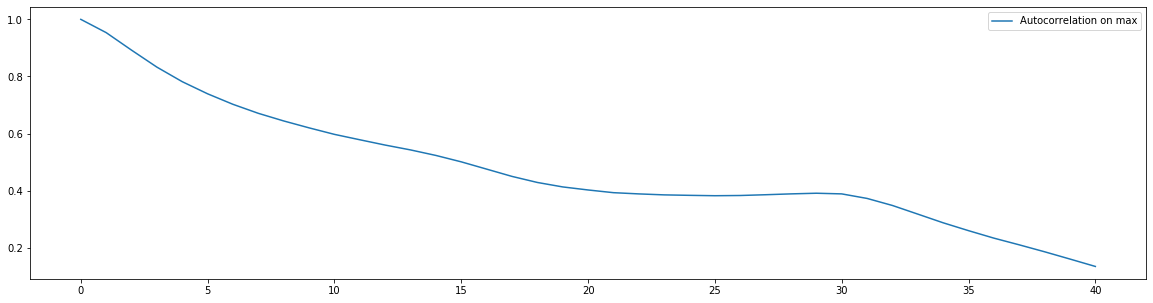

In [26]:
# Autocorrelation
plt.plot(acf(train_data, fft=True, unbiased=True), label='Autocorrelation on max')
plt.legend();

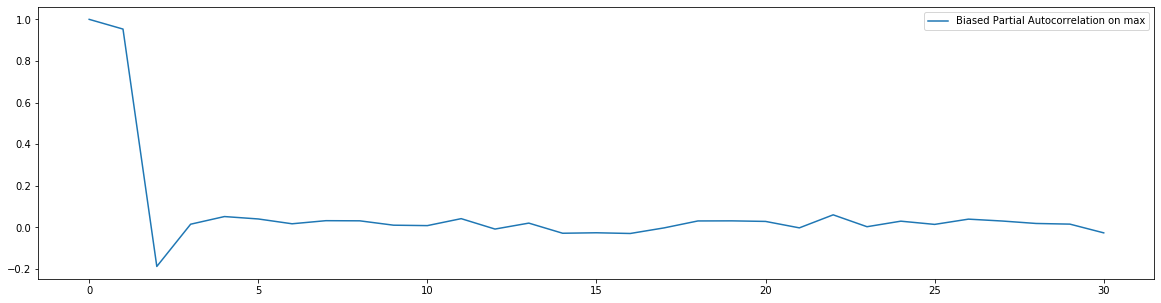

In [27]:
# Biased Partial Autocorrelation using 'mle' - maximum likelihood estimation - with Yule-Walker
plt.plot(pacf_yw(train_data, nlags=30, method='mle'), label='Biased Partial Autocorrelation on max')
plt.legend();

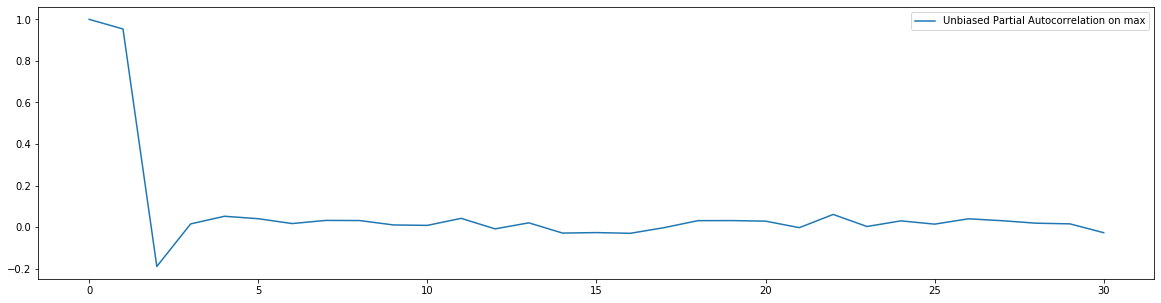

In [28]:
# Unbiased Partial Autocorrelation
plt.plot(pacf_yw(train_data, nlags=30, method='unbiased'), label='Unbiased Partial Autocorrelation on max')
plt.legend();

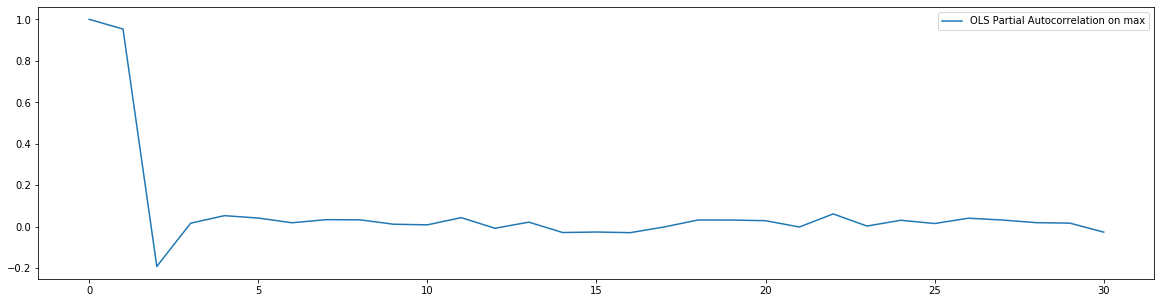

In [29]:
# Partial Autocorrelation using ordinary least squares (OLS) estimates for each lag instead of Yule-Walker.
plt.plot(pacf_ols(train_data, nlags=30), label='OLS Partial Autocorrelation on max')
plt.legend();

#### Lags, Autocorrelation, and Partial Autocorrelation
The arrays returned by <tt>.acf()</tt> and <tt>.pacf_yw()</tt> show the magnitude of the autocorrelation for a given $y$ at time $t$. let's look at the data itself for evidence of autocorrelation.

Pandas has a built-in plotting function that plots increasing $y_t$ values on the horizontal axis against lagged versions of the values $y_{t+1}$ on the vertical axis. If a dataset is non-stationary with an upward trend, then neighboring values should trend in the same way:

In [30]:
from pandas.plotting import lag_plot

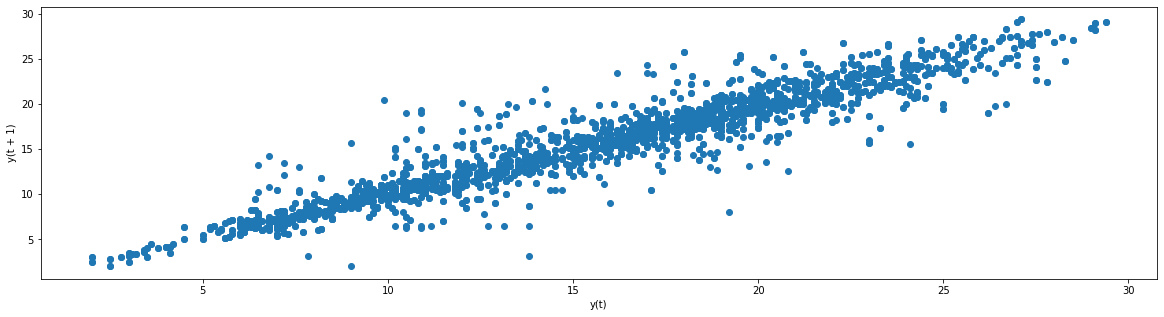

In [31]:
lag_plot(train_data);

Visually this shows evidence of a very strong autocorrelation; as $y_t$ values increase, nearby (lagged) values also increase.

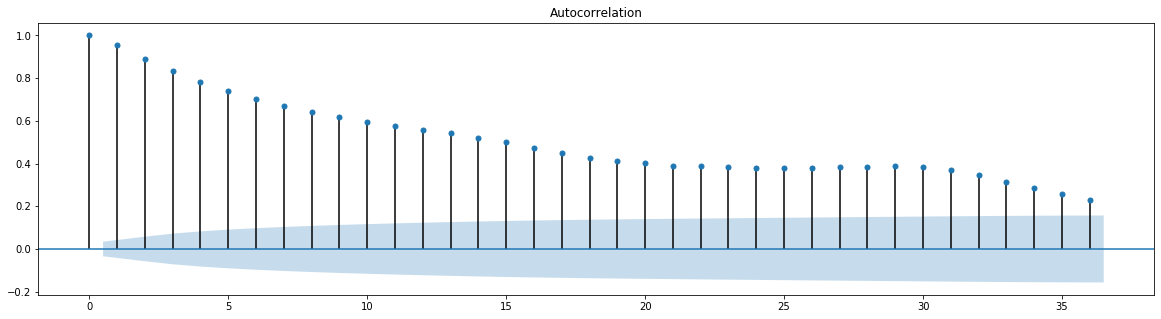

In [32]:
# Autocorrelation
plot_acf(train_data);

##### Both min and max values from 5 critical stations have gradual decline, not sharp drop, in their autocorelation plots which indicate the data is non-stationary  
1. The Autocorrelation plots show POSITIVE autocorrelation at the first lag (lag-1), then they suggest to use AR terms in the relation to the lag
2. If the Autocorrelation plots show NEGATIVE autocorrelation at the first lag, then they suggest to use MA terms in the relation to the lag

ACF is best for deciding MA models

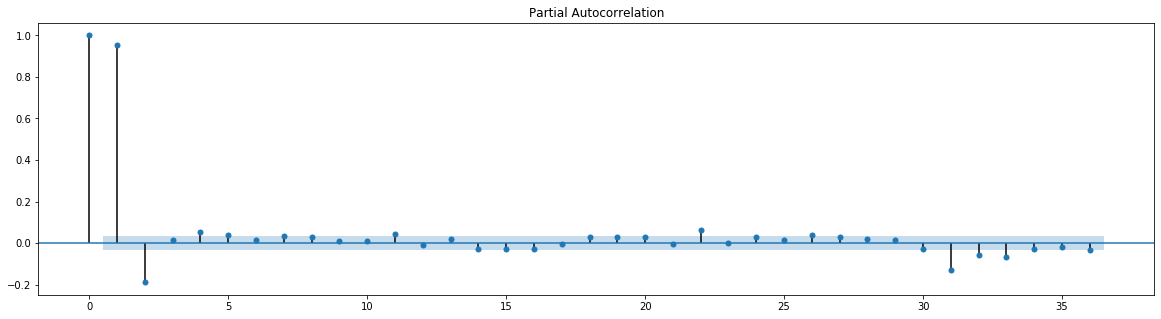

In [33]:
# Partial Autocorrelation
plot_pacf(train_data);

##### Both min and max values from 5 critical stations have sharp drop in their partial autocorelation plots  
1. Typically a sharp drop after lag k suggests an AR-k model should be used. PACF is best for deciding AR models
2. If there is an gradual decline, it suggests an MA model

In our case of these stations, k = 2 on AR models

### Pyramid ARIMA aka Auto-ARIMA

In [34]:
from statsmodels.tsa.arima_model import ARIMA

In [35]:
help(ARIMA)

Help on class ARIMA in module statsmodels.tsa.arima_model:

class ARIMA(ARMA)
 |  ARIMA(endog, order, exog=None, dates=None, freq=None, missing='none')
 |  
 |  Autoregressive Integrated Moving Average ARIMA(p,d,q) Model
 |  
 |  Parameters
 |  ----------
 |  endog : array_like
 |      The endogenous variable.
 |  order : iterable
 |      The (p,d,q) order of the model for the number of AR parameters,
 |      differences, and MA parameters to use.
 |  exog : array_like, optional
 |      An optional array of exogenous variables. This should *not* include a
 |      constant or trend. You can specify this in the `fit` method.
 |  dates : array_like, optional
 |      An array-like object of datetime objects. If a pandas object is given
 |      for endog or exog, it is assumed to have a DateIndex.
 |  freq : str, optional
 |      The frequency of the time-series. A Pandas offset or 'B', 'D', 'W',
 |      'M', 'A', or 'Q'. This is optional if dates are given.
 |  
 |  
 |  Notes
 |  -----
 |

In [36]:
from pmdarima import auto_arima

In [37]:
help(auto_arima)

Help on function auto_arima in module pmdarima.arima.auto:

auto_arima(y, exogenous=None, start_p=2, d=None, start_q=2, max_p=5, max_d=2, max_q=5, start_P=1, D=None, start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5, m=1, seasonal=True, stationary=False, information_criterion='aic', alpha=0.05, test='kpss', seasonal_test='ocsb', stepwise=True, n_jobs=1, start_params=None, trend=None, method='lbfgs', maxiter=50, offset_test_args=None, seasonal_test_args=None, suppress_warnings=False, error_action='warn', trace=False, random=False, random_state=None, n_fits=10, return_valid_fits=False, out_of_sample_size=0, scoring='mse', scoring_args=None, with_intercept=True, sarimax_kwargs=None, **fit_args)
    Automatically discover the optimal order for an ARIMA model.
    
    The auto-ARIMA process seeks to identify the most optimal
    parameters for an ``ARIMA`` model, settling on a single fitted ARIMA model.
    This process is based on the commonly-used R function,
    ``forecast::auto.arima``

#### Resample to monthly data points

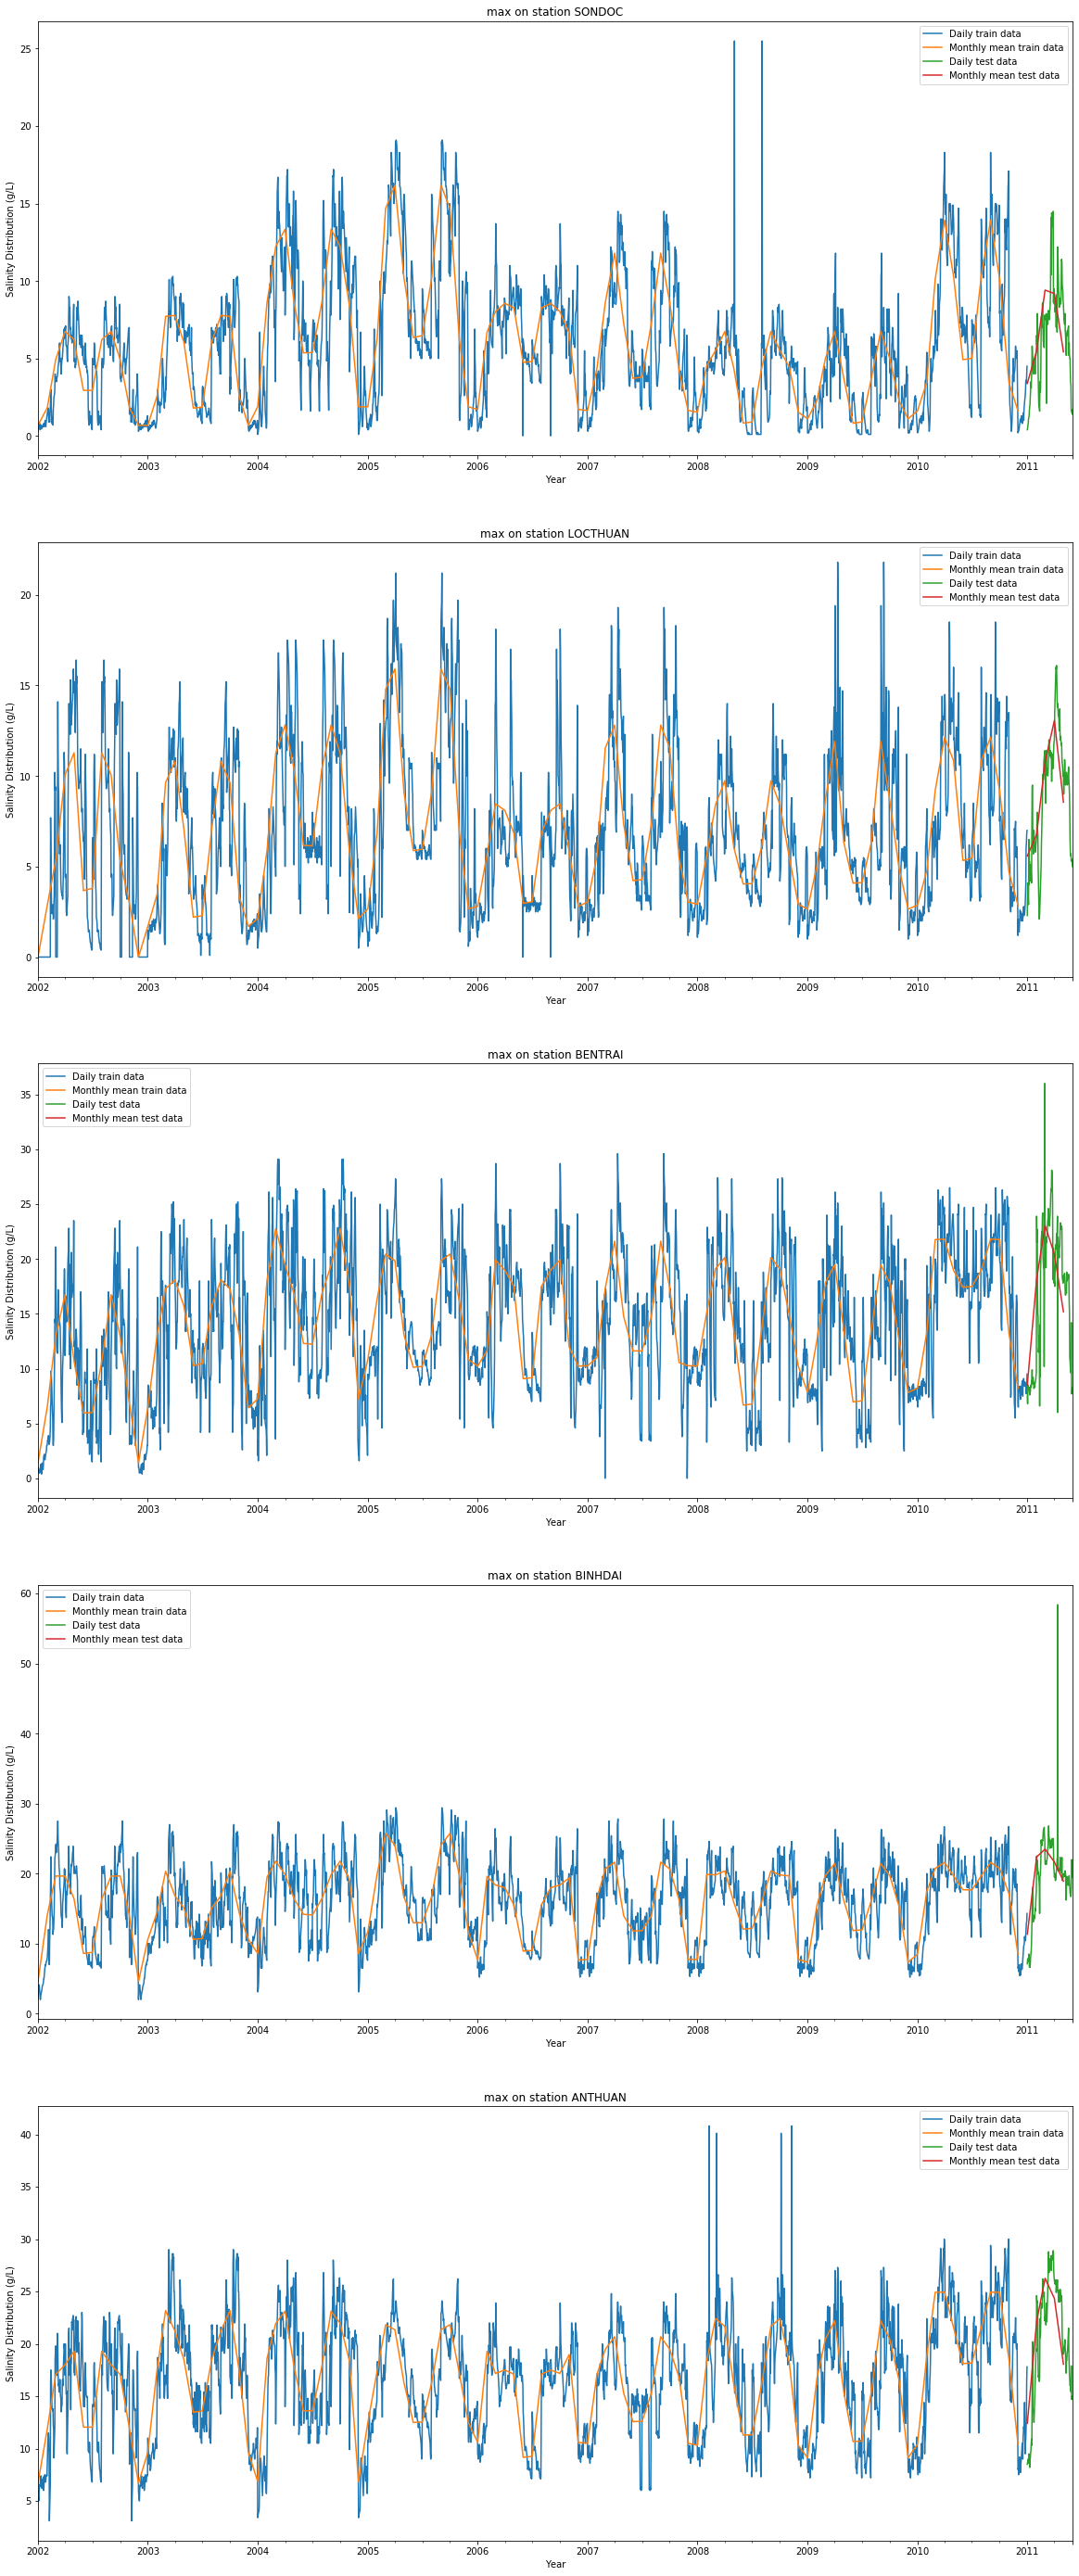

In [38]:
fig, axes = plt.subplots(nrows=station_count, ncols=1, figsize=(20, 10 * station_count))

for index, code in zip(range(0, station_count), station_codes):
    ax = axes[index]
    
    # train
    df = train_station_data[code]
    df1 = df[value_field].resample('MS').mean()
    train_station_data[code] = [df, df1]
    
    df[value_field].plot(ax=ax, label='Daily train data', legend=True)
    df1.plot(ax=ax, label='Monthly mean train data', legend=True)
    
    # test
    df = test_station_data[code]
    df1 = df[value_field].resample('MS').mean()
    test_station_data[code] = [df, df1]
    
    df[value_field].plot(ax=ax, label='Daily test data', legend=True)
    df1.plot(ax=ax, label='Monthly mean test data', legend=True)
    
    # plot annotation
    ax.set_title(f'{value_field} on station {code}')
    ax.set_xlabel('Year')
    ax.set_ylabel('Salinity Distribution (g/L)');

#### Grid search for best SARIMAX parameters

In [39]:
# using monthly data
train_data = train_station_data[station_code][1]
test_data = test_station_data[station_code][1]

In [40]:
def grid_search_sarimax(data, trace=True):
     return auto_arima(data,
                       start_p=0, start_q=0,
                       max_p=6, max_q=6, 
                       m=12,                    # 12 month season
                       start_P=0, 
                       seasonal=True,
                       d=None, 
                       D=1, 
                       trace=trace,
                       error_action='ignore',   # we don't want to know if an order does not work
                       suppress_warnings=True,  # we don't want convergence warnings
                       stepwise=True)           # set to stepwise

In [41]:
stepwise_model = grid_search_sarimax(train_data)

Performing stepwise search to minimize aic
Fit ARIMA: (0, 0, 0)x(0, 1, 1, 12) (constant=True); AIC=448.015, BIC=455.708, Time=0.209 seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 12) (constant=True); AIC=478.098, BIC=483.227, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(1, 1, 0, 12) (constant=True); AIC=420.449, BIC=430.707, Time=0.085 seconds
Fit ARIMA: (0, 0, 1)x(0, 1, 1, 12) (constant=True); AIC=435.761, BIC=446.019, Time=0.280 seconds
Near non-invertible roots for order (0, 0, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 12) (constant=False); AIC=478.651, BIC=481.216, Time=0.009 seconds
Fit ARIMA: (1, 0, 0)x(0, 1, 0, 12) (constant=True); AIC=470.183, BIC=477.876, Time=0.028 seconds
Fit ARIMA: (1, 0, 0)x(2, 1, 0, 12) (constant=True); AIC=422.006, BIC=434.828, Time=0.221 seconds
Fit ARIMA: (1, 0, 0)x(1, 1, 1, 12) (constant=True); AIC=421.908, BIC=434.730, Time=0.140 seconds
Fit ARIMA: (1, 0, 0)x

In [42]:
stepwise_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  108
Model:             SARIMAX(1, 0, 1)x(2, 1, 1, 12)   Log Likelihood                -202.723
Date:                            Sat, 21 Mar 2020   AIC                            419.446
Time:                                    23:07:29   BIC                            437.396
Sample:                                         0   HQIC                           426.702
                                            - 108                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0378      0.062      0.608      0.543      -0.084       0.160
ar.L1          0.7901      0.110      7.184      0.000       0.575       1.006
ma.L1         -0.3090      0.175     -1.770      0.077      -0.651       0.033
ar.S.L12       0.0435      0.391      0.111      0.911      -0.722       0.809
ar.S.L24       0.4090      0.332      1.234      0.217      -0.241       1.059
ma.S.L12      -0.9990     48.316     -0.021      0.984     -95.696      93.698
sigma2         3.2355    155.308      0.021      0.983    -301.162     307.633
===================================================================================
Ljung-Box (Q):                       26.86   Jarque-Bera (JB):                 2.32
Prob(Q):                              0.94   Prob(JB):                         0.31
Heteroskedasticity (H):               0.43   Skew:                             0.38
Prob(H) (two-sided):                  0.02   Kurtosis:                         2.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [43]:
# fit the model with train set - NO NEED TO FIT IF USING THE SAME TRAINING SET
#stepwise_model.fit(train_data)

In [44]:
# use model to predict
predictions = stepwise_model.predict(n_periods=len(test_data))

In [45]:
predictions = pd.Series(predictions, index=test_data.index)

#### Verify predictions against test set

In [46]:
predictions

date
2011-01-01    8.58379
2011-02-01   17.18868
2011-03-01   21.14307
2011-04-01   21.75088
2011-05-01   17.44232
Freq: MS, dtype: float64

In [47]:
test_data

date
2011-01-01   11.33871
2011-02-01   22.37500
2011-03-01   23.48710
2011-04-01   21.64667
2011-05-01   18.90968
Freq: MS, Name: max, dtype: float64

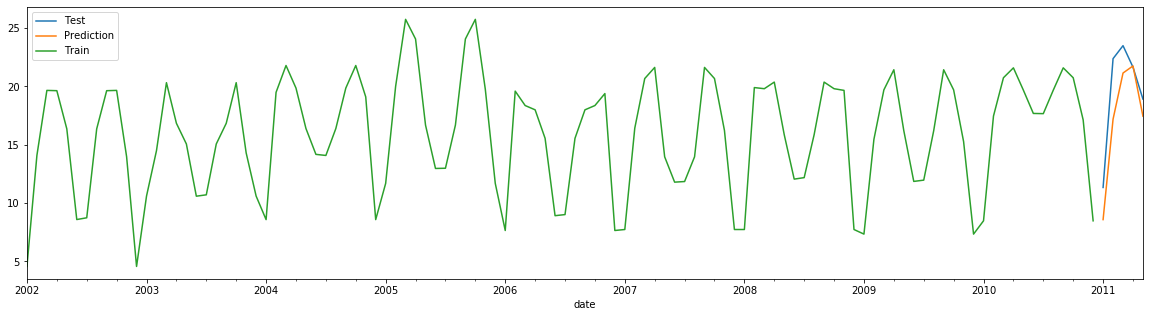

In [48]:
test_data.plot(legend=True, label='Test')
predictions.plot(legend=True, label='Prediction')
train_data.plot(legend=True, figsize=(20,5), label='Train');

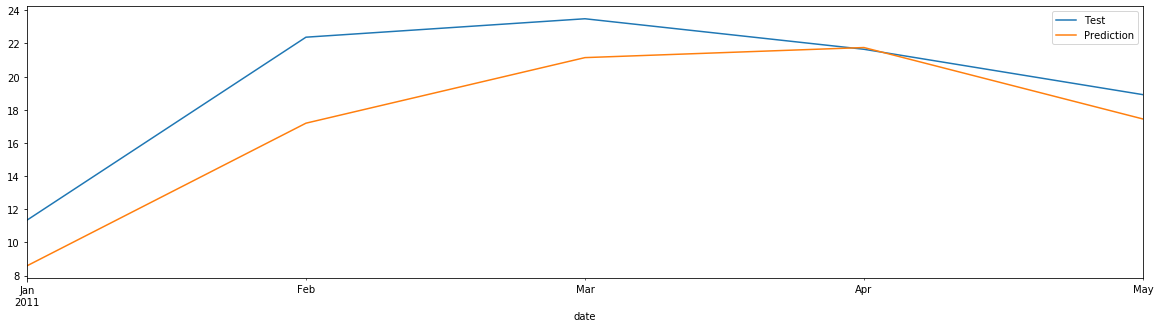

In [49]:
test_data.plot(legend=True, figsize=(20,5), label='Test')
predictions.plot(legend=True, label='Prediction');

#### Evaluating models

In [50]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [51]:
test_data.describe()

count    5.00000
mean    19.55143
std      4.89164
min     11.33871
25%     18.90968
50%     21.64667
75%     22.37500
max     23.48710
Name: max, dtype: float64

In [52]:
predictions.describe()

count    5.00000
mean    17.22175
std      5.25723
min      8.58379
25%     17.18868
50%     17.44232
75%     21.14307
max     21.75088
dtype: float64

In [53]:
test_std = test_data.std()

test_std

4.891642328079326

In [54]:
mae = mean_absolute_error(test_data, predictions)

mae

2.3713680790078353

In [55]:
mse = mean_squared_error(test_data, predictions)

mse

8.429195345199748

In [56]:
rmse = np.sqrt(mse)

rmse

2.903307655967543

In [57]:
print(f'Prediction RMSE {round(rmse, 2)} vs. Test STD {round(test_std, 2)}')

Prediction RMSE 2.9 vs. Test STD 4.89


In [58]:
import math

In [59]:
error_percent = math.ceil(100.0 * rmse / test_std)
print(f'Error in form of RMSE is about {error_percent}% of Test STD => {"GOOD ENOUGH" if error_percent <= 50 else "BAD"}')

Error in form of RMSE is about 60% of Test STD => BAD


#### Save model

In [60]:
import pickle

In [61]:
def save_model(model, code):
    with open(f'../../model/{code}.pkl', 'wb') as pkl:
        pickle.dump(model, pkl)

In [62]:
save_model(stepwise_model, station_code)

### Predict entire test year

#### Reload model from disk

In [63]:
def load_model(code):
    with open(f'../../model/{code}.pkl', 'rb') as pkl:
        return pickle.load(pkl)

In [64]:
stepwise_model = load_model(station_code)

#### Predict from the loaded model

In [65]:
predictions = stepwise_model.predict(n_periods=12)

In [66]:
predictions = pd.Series(predictions, index=pd.date_range(start=f'{test_year}-01-01', end=f'{test_year}-12-31', freq='MS'))

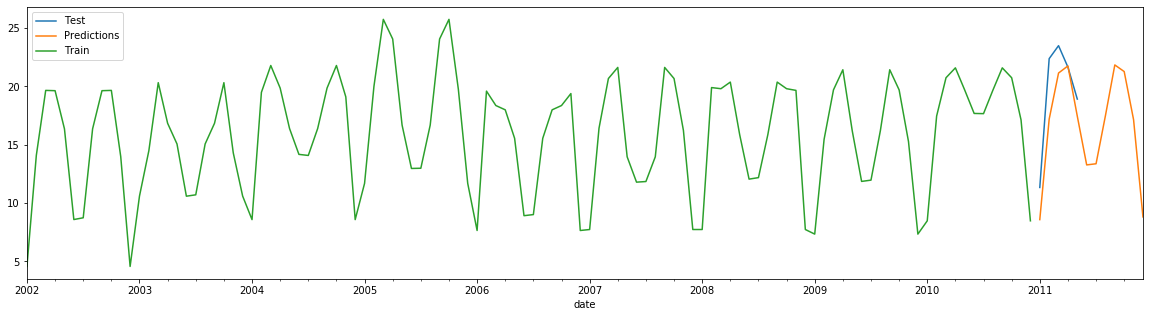

In [67]:
test_data.plot(legend=True, label='Test')
predictions.plot(legend=True, label='Predictions')
train_data.plot(legend=True, figsize=(20,5), label='Train');

### Expand evaluation to other years where data are available

In [68]:
eval_data = pd.DataFrame()

eval_start_year = 2012
eval_end_year = 2021

In [69]:
for year in range(eval_start_year, eval_end_year + 1):
    try:
        df = pd.read_csv(f'../../data/evaluation/{station_code}-{year}.csv', parse_dates=['date'])
        df.set_index('date', inplace=True)
        
        # using max resample since this is further from the side of test set
        df = df[value_field].resample('MS').max()

        if eval_data.empty:
            eval_data = df
        else:
            eval_data = pd.concat([eval_data, df])
    except:
        continue

In [70]:
eval_data.head()

date
2012-02-01   20.50000
2012-03-01   10.40000
2012-04-01   21.60000
2012-05-01   22.27500
2012-06-01   21.12500
Name: max, dtype: float64

In [71]:
eval_data.tail()

date
2016-02-01   27.00000
2016-03-01   27.20000
2016-04-01   23.90000
2016-05-01   21.70000
2016-06-01   18.60000
Name: max, dtype: float64

In [72]:
forecast = stepwise_model.predict(n_periods=(eval_end_year - eval_start_year + 1) * 12)

In [73]:
forecast = pd.Series(forecast, index=pd.date_range(start=f'{eval_start_year}-01-01', end=f'{eval_end_year}-12-31', freq='MS'))

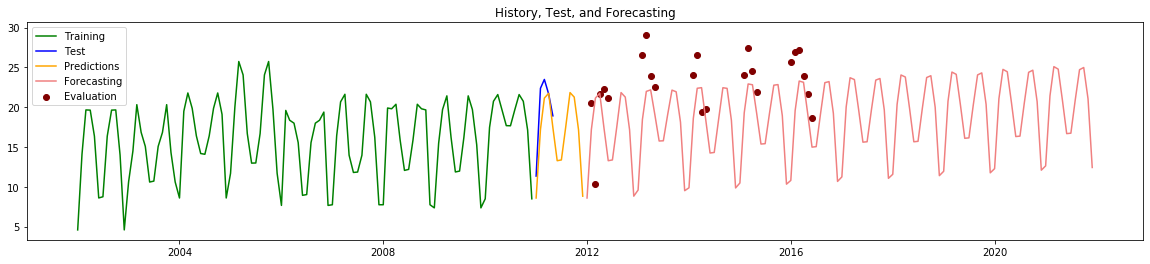

In [74]:
fig, ax = plt.subplots(figsize=(20,4))

ax.plot(train_data.index, train_data, c='green', label='Training')
ax.plot(test_data.index, test_data, c='blue', label='Test')
ax.plot(predictions.index, predictions, c='orange', label='Predictions')
ax.plot(forecast.index, forecast, c='lightcoral', label='Forecasting')
ax.scatter(x=eval_data.index, y=eval_data, c='maroon', label='Evaluation')

plt.title('History, Test, and Forecasting')
ax.legend();

In [75]:
eval_end_year

2021

### Construct models for all top stations

In [76]:
for code, df in train_station_data.items():
    print(f'>>>>> Station {code} Grid Search Summary {49 * ">"}')
    
    train_data = train_station_data[code][1]  # using monthly data
    model = grid_search_sarimax(train_data, trace=False)
    print(model.summary())
    save_model(model, code)
    
    print(80 * '>')

>>>>> Station SONDOC Grid Search Summary >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  108
Model:             SARIMAX(5, 0, 1)x(1, 1, 1, 12)   Log Likelihood                -179.386
Date:                            Sat, 21 Mar 2020   AIC                            378.773
Time:                                    23:08:02   BIC                            404.416
Sample:                                         0   HQIC                           389.138
                                            - 108                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0314  

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  108
Model:             SARIMAX(1, 0, 0)x(1, 1, [1], 12)   Log Likelihood                -205.307
Date:                              Sat, 21 Mar 2020   AIC                            420.613
Time:                                      23:08:39   BIC                            433.435
Sample:                                           0   HQIC                           425.796
                                              - 108                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1253      0.082      1.524      0.128      -0.036       0.286
ar.L1          0.55